Entraînement des modèles Lasso avec validation temporelle...

Top 3 modèles sélectionnés:
Modèle 1: Score test = 0.288, Stabilité = 0.980
  Variables: ['unemployment', 'inflation', 'delta_logit_td_lag1']
Modèle 2: Score test = 0.261, Stabilité = 0.978
  Variables: ['gdp_growth', 'inflation', 'delta_logit_td_lag1']
Modèle 3: Score test = 0.261, Stabilité = 0.975
  Variables: ['inflation', 'delta_logit_td_lag1']

Projections avec le modèle 1...

Projections avec le modèle 2...

Projections avec le modèle 3...

RÉSUMÉ DES PROJECTIONS

Modèle_1:
  Optimiste: 3.25% (période finale)
  Central: 3.34% (période finale)
  Pessimiste: 3.42% (période finale)

Modèle_2:
  Optimiste: 3.13% (période finale)
  Central: 3.28% (période finale)
  Pessimiste: 3.44% (période finale)

Modèle_3:
  Optimiste: 3.13% (période finale)
  Central: 3.28% (période finale)
  Pessimiste: 3.44% (période finale)


c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X 

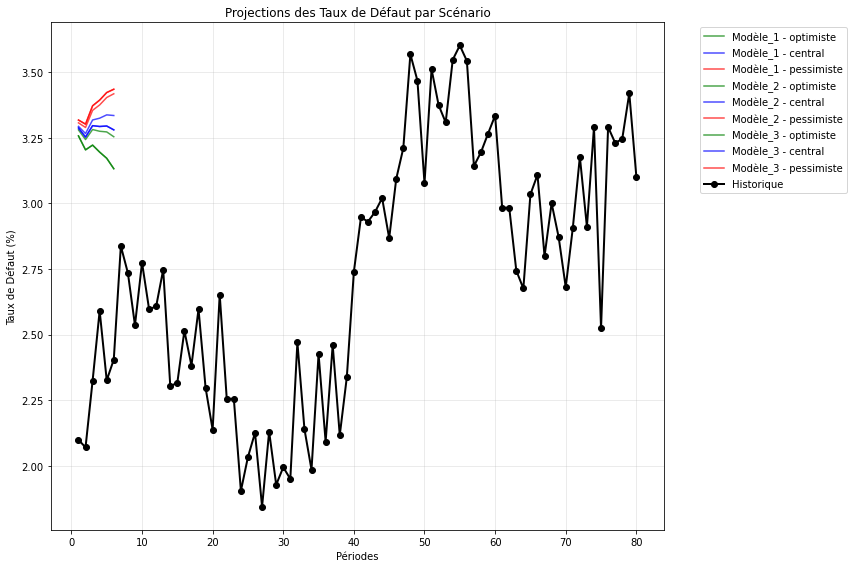

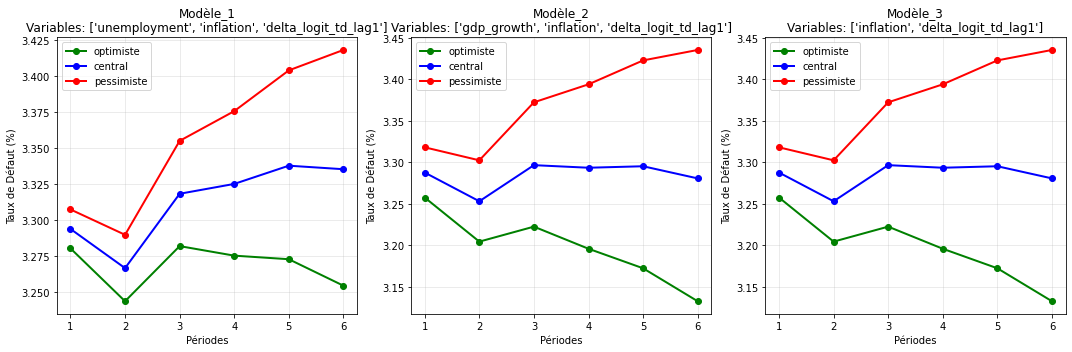

In [1]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

class RobustTimeSeriesLasso:
    def __init__(self, data, target_col='delta_logit_td', macro_vars=None,
                 n_splits=5, min_train_size=20, gap=1):
        
        self.data = data.copy()
        self.target_col = target_col
        self.macro_vars = macro_vars or []
        self.n_splits = n_splits
        self.min_train_size = min_train_size
        self.gap = gap
        self.best_models = []
        
    def prepare_features(self):
        """Préparation des features avec retards (lag AR limité à 1)"""
        df = self.data.copy()
        
        # Seulement lag 1 pour les variables AR
        df['logit_td_lag1'] = df['logit_td'].shift(1)
        df['delta_logit_td_lag1'] = df['delta_logit_td'].shift(1)
        
        return df.dropna()
    
    def time_series_cv_lasso(self, X_train, y_train, alphas=np.logspace(-4, 2, 50)):
        """Validation croisée temporelle pour sélection du alpha Lasso"""
        
        tscv = TimeSeriesSplit(n_splits=self.n_splits, gap=self.gap)
        alpha_scores = []
        
        for alpha in alphas:
            fold_scores = []
            
            for train_idx, val_idx in tscv.split(X_train):
                # Split temporel
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                # Entraînement Lasso
                lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
                lasso.fit(X_train_fold, y_train_fold)
                
                # Évaluation sur validation set
                y_pred = lasso.predict(X_val_fold)
                score = -mean_squared_error(y_val_fold, y_pred)
                fold_scores.append(score)
            
            alpha_scores.append({
                'alpha': alpha,
                'mean_score': np.mean(fold_scores),
                'std_score': np.std(fold_scores)
            })
        
        # Meilleur alpha
        best_alpha = max(alpha_scores, key=lambda x: x['mean_score'])['alpha']
        return best_alpha, alpha_scores
    
    def evaluate_model_stability(self, model, X, y):
        """Évalue la stabilité du modèle dans le temps"""
        coefficients = []
        
        for i in range(self.min_train_size, len(X)):
            X_train = X.iloc[:i]
            y_train = y.iloc[:i]
            
            model.fit(X_train, y_train)
            coefficients.append(model.coef_.copy())
        
        # Mesure de stabilité des coefficients
        coef_std = np.std(coefficients, axis=0)
        stability_score = 1 / (1 + np.mean(coef_std))
        
        return stability_score
    
    def find_best_lasso_models(self, top_n=10):
        """Trouve les meilleurs modèles Lasso avec validation temporelle robuste"""
        
        df = self.prepare_features()
        
        # Features disponibles (macro + seulement lag 1 AR)
        available_features = self.macro_vars + ['logit_td_lag1', 'delta_logit_td_lag1']
        available_features = [f for f in available_features if f in df.columns]
        
        results = []
        
        # Évaluation de chaque combinaison (1 à 4 variables)
        for k in range(1, 5):
            for feature_combo in combinations(available_features, k):
                feature_combo = list(feature_combo)
                
                try:
                    X = df[feature_combo]
                    y = df[self.target_col]
                    
                    # Split temporel
                    split_idx = int(len(X) * 0.7)
                    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
                    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
                    
                    if len(X_train) < self.min_train_size:
                        continue
                    
                    # Optimisation du alpha avec validation temporelle
                    best_alpha, alpha_scores = self.time_series_cv_lasso(X_train, y_train)
                    
                    # Entraînement du modèle final
                    lasso_final = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
                    lasso_final.fit(X_train, y_train)
                    
                    # Évaluation sur test set
                    test_score = lasso_final.score(X_test, y_test)
                    
                    # Évaluation de la stabilité
                    stability_score = self.evaluate_model_stability(
                        Lasso(alpha=best_alpha, max_iter=10000), X_train, y_train
                    )
                    
                    results.append({
                        'features': feature_combo,
                        'model': lasso_final,
                        'test_score': test_score,
                        'best_alpha': best_alpha,
                        'stability_score': stability_score,
                        'n_selected_vars': np.sum(lasso_final.coef_ != 0),
                        'combined_score': test_score * stability_score,
                        'feature_importance': dict(zip(feature_combo, lasso_final.coef_))
                    })
                    
                except Exception as e:
                    continue
        
        # Trier par score combiné (performance + stabilité)
        results.sort(key=lambda x: x['combined_score'], reverse=True)
        self.best_models = results[:top_n]
        return self.best_models

class TimeSeriesProjector:
    def __init__(self, initial_data):
        """
        Classe pour les projections avec gestion de l'aspect autorégressif
        """
        self.initial_data = initial_data.copy()
        self.projection_history = []
        
    def logit_to_default_rate(self, logit_val):
        """Convertit logit en taux de défaut"""
        return np.exp(logit_val) / (1 + np.exp(logit_val))
    
    def default_rate_to_logit(self, td):
        """Convertit taux de défaut en logit"""
        if td <= 0:
            return -10
        elif td >= 1:
            return 10
        return np.log(td / (1 - td))
    
    def create_scenarios(self, base_macro_data, scenario_type='central'):
        """
        Crée des scénarios macroéconomiques selon le type
        """
        scenarios = {
            'optimiste': 1.1,    # +10% pour les variables favorables
            'central': 1.0,      # Statu quo
            'pessimiste': 0.9    # -10% pour les variables favorables
        }
        
        scenario_data = base_macro_data.copy()
        multiplier = scenarios[scenario_type]
        
        # Appliquer le multiplicateur selon le sens des variables
        for var in scenario_data.columns:
            if var in ['gdp_growth', 'inflation']:  # Variables pro-cycliques
                scenario_data[var] = scenario_data[var] * multiplier
            elif var in ['unemployment']:  # Variables contra-cycliques
                scenario_data[var] = scenario_data[var] * (2 - multiplier)
        
        return scenario_data
    
    def project_with_model(self, model_info, future_macro_data, 
                          initial_logit_td, n_periods=6, scenario='central'):
        """
        Fait des projections avec gestion de l'aspect autorégressif
        
        Paramètres:
        -----------
        scenario : 'optimiste', 'central', 'pessimiste'
        """
        model = model_info['model']
        features = model_info['features']
        
        # Appliquer le scénario
        scenario_macro_data = self.create_scenarios(future_macro_data, scenario)
        
        projections = []
        current_logit = initial_logit_td
        
        # Initialiser le lag 1
        logit_lag1 = self.initial_data['logit_td'].iloc[-1] if 'logit_td' in self.initial_data.columns else initial_logit_td
        
        for period in range(n_periods):
            # Préparer le vecteur de features pour cette période
            feature_vector = {}
            
            for feature in features:
                if feature in scenario_macro_data.columns:
                    # Variable macro - prendre la valeur du scénario
                    feature_vector[feature] = scenario_macro_data[feature].iloc[period]
                elif feature == 'logit_td_lag1':
                    # Retard AR - utiliser la valeur précédente
                    feature_vector[feature] = logit_lag1
                elif feature == 'delta_logit_td_lag1':
                    # Différence retard - calculer à partir des logits
                    if period == 0:
                        # Pour la première période, utiliser la dernière différence historique
                        if 'delta_logit_td' in self.initial_data.columns:
                            feature_vector[feature] = self.initial_data['delta_logit_td'].iloc[-1]
                        else:
                            feature_vector[feature] = 0
                    else:
                        # Pour les périodes suivantes, utiliser la différence des projections
                        feature_vector[feature] = current_logit - logit_lag1
                else:
                    feature_vector[feature] = 0
            
            # Créer le vecteur dans le bon ordre
            X_pred = np.array([[feature_vector[f] for f in features]])
            
            # Faire la prédiction du delta logit
            delta_logit_pred = model.predict(X_pred)[0]
            
            # Calculer le nouveau logit
            new_logit_td = current_logit + delta_logit_pred
            
            # Convertir en taux de défaut
            default_rate_pred = self.logit_to_default_rate(new_logit_td)
            
            # Stocker la projection
            projection_record = {
                'period': period + 1,
                'scenario': scenario,
                'delta_logit_pred': delta_logit_pred,
                'logit_td_pred': new_logit_td,
                'default_rate_pred': default_rate_pred,
                'current_logit': current_logit
            }
            
            # Ajouter les valeurs des features utilisées
            for feature in features:
                projection_record[feature] = feature_vector[feature]
            
            projections.append(projection_record)
            
            # Mettre à jour pour la période suivante
            logit_lag1 = current_logit  # Le logit courant devient le lag pour la période suivante
            current_logit = new_logit_td
        
        return pd.DataFrame(projections)

def plot_scenario_projections(projections_dict, historical_td=None, title="Projections des Taux de Défaut par Scénario"):
    """
    Trace les projections pour les trois scénarios
    """
    plt.figure(figsize=(12, 8))
    
    # Couleurs pour les scénarios
    colors = {'optimiste': 'green', 'central': 'blue', 'pessimiste': 'red'}
    
    for model_name, model_data in projections_dict.items():
        for scenario in ['optimiste', 'central', 'pessimiste']:
            if scenario in model_data:
                projections = model_data[scenario]
                plt.plot(projections['period'], 
                        projections['default_rate_pred'] * 100,  # Convertir en %
                        label=f'{model_name} - {scenario}',
                        color=colors[scenario],
                        linestyle='--' if 'pessimiste' in model_name else '-',
                        alpha=0.7)
    
    # Ajouter les données historiques si disponibles
    if historical_td is not None:
        historical_periods = range(1, len(historical_td) + 1)
        plt.plot(historical_periods, historical_td * 100, 
                label='Historique', color='black', linewidth=2, marker='o')
    
    plt.xlabel('Périodes')
    plt.ylabel('Taux de Défaut (%)')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def comprehensive_timeseries_analysis(data, macro_vars, target_col='delta_logit_td', 
                                    logit_col='logit_td', top_models=3, n_periods=6,
                                    base_macro_data=None):
    """
    Analyse complète avec modèles Lasso temporels et projections multi-scénarios
    """
    
    # 1. Initialisation et entraînement des modèles
    print("Entraînement des modèles Lasso avec validation temporelle...")
    lasso_analyzer = RobustTimeSeriesLasso(
        data=data,
        target_col=target_col,
        macro_vars=macro_vars,
        n_splits=5,
        gap=1
    )
    
    best_models = lasso_analyzer.find_best_lasso_models(top_n=top_models)
    
    print(f"\nTop {len(best_models)} modèles sélectionnés:")
    for i, model_info in enumerate(best_models):
        print(f"Modèle {i+1}: Score test = {model_info['test_score']:.3f}, "
              f"Stabilité = {model_info['stability_score']:.3f}")
        print(f"  Variables: {model_info['features']}")
    
    # 2. Préparation des projections
    last_logit = data[logit_col].iloc[-1]
    projector = TimeSeriesProjector(data.tail(2))  # Utiliser les 2 dernières observations
    
    # 3. Génération de données de base si non fournies
    if base_macro_data is None:
        base_macro_data = pd.DataFrame({
            var: [data[var].iloc[-1] for _ in range(n_periods)] for var in macro_vars
        })
    
    # 4. Projections multi-scénarios avec chaque modèle
    all_projections = {}
    
    for i, model_info in enumerate(best_models):
        print(f"\nProjections avec le modèle {i+1}...")
        
        model_projections = {}
        
        for scenario in ['optimiste', 'central', 'pessimiste']:
            projections_df = projector.project_with_model(
                model_info=model_info,
                future_macro_data=base_macro_data,
                initial_logit_td=last_logit,
                n_periods=n_periods,
                scenario=scenario
            )
            
            model_projections[scenario] = projections_df
        
        all_projections[f'Modèle_{i+1}'] = model_projections
    
    # 5. Affichage des résultats
    print("\n" + "="*60)
    print("RÉSUMÉ DES PROJECTIONS")
    print("="*60)
    
    for model_name, scenarios in all_projections.items():
        print(f"\n{model_name}:")
        for scenario, projections in scenarios.items():
            final_td = projections['default_rate_pred'].iloc[-1] * 100
            print(f"  {scenario.capitalize()}: {final_td:.2f}% (période finale)")
    
    # 6. Visualisation
    historical_td = data['default_rate'] if 'default_rate' in data.columns else None
    
    plot_scenario_projections(all_projections, historical_td)
    
    # 7. Graphique détaillé par modèle
    fig, axes = plt.subplots(1, len(all_projections), figsize=(15, 5))
    if len(all_projections) == 1:
        axes = [axes]
    
    for idx, (model_name, scenarios) in enumerate(all_projections.items()):
        ax = axes[idx]
        
        for scenario, color in zip(['optimiste', 'central', 'pessimiste'], ['green', 'blue', 'red']):
            projections = scenarios[scenario]
            ax.plot(projections['period'], projections['default_rate_pred'] * 100,
                   label=scenario, color=color, linewidth=2, marker='o')
        
        ax.set_title(f'{model_name}\nVariables: {best_models[idx]["features"]}')
        ax.set_xlabel('Périodes')
        ax.set_ylabel('Taux de Défaut (%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'lasso_analyzer': lasso_analyzer,
        'projector': projector,
        'all_projections': all_projections,
        'best_models': best_models
    }

# Exemple d'utilisation
if __name__ == "__main__":
    # Données d'exemple plus réalistes
    np.random.seed(42)
    n_obs = 80
    
    # Créer une série temporelle réaliste pour les taux de défaut
    trend = np.linspace(0.02, 0.035, n_obs)  # Tendance légèrement croissante
    seasonal = 0.005 * np.sin(np.linspace(0, 4*np.pi, n_obs))  # Composante saisonnière
    noise = np.random.normal(0, 0.002, n_obs)  # Bruit
    
    default_rates = trend + seasonal + noise
    default_rates = np.clip(default_rates, 0.001, 0.1)  # Limiter entre 0.1% et 10%
    
    sample_data = pd.DataFrame({
        'default_rate': default_rates,
        'logit_td': np.log(default_rates / (1 - default_rates)),
        'gdp_growth': np.random.normal(2.0, 0.5, n_obs),
        'unemployment': np.random.normal(7.5, 0.8, n_obs),
        'inflation': np.random.normal(2.2, 0.3, n_obs),
    })
    
    # Calcul du delta logit
    sample_data['delta_logit_td'] = sample_data['logit_td'].diff()
    
    macro_variables = ['gdp_growth', 'unemployment', 'inflation']
    
    # Données de base pour les projections (scénario central)
    base_future_data = pd.DataFrame({
        'gdp_growth': [2.1, 2.0, 1.9, 1.8, 1.9, 2.0],
        'unemployment': [7.4, 7.3, 7.2, 7.1, 7.0, 6.9],
        'inflation': [2.1, 2.2, 2.3, 2.4, 2.5, 2.6]
    })
    
    # Lancement de l'analyse complète
    results = comprehensive_timeseries_analysis(
        data=sample_data,
        macro_vars=macro_variables,
        base_macro_data=base_future_data,
        top_models=3,
        n_periods=6
    )